In [1]:
#Classification Setup
using GLMNet
using RDatasets
using MLBase
using Plots
using DecisionTree
using Distances
using NearestNeighbors
using Random
using LinearAlgebra
using DataStructures
using LIBSVM

In [13]:
findaccuracy(predictedvals,groundtruthvals) = sum(predictedvals.==groundtruthvals)/length(groundtruthvals)

findaccuracy (generic function with 1 method)

In [2]:
iris = dataset("datasets", "iris") #Load Iris Dataset

Row,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
,Float64,Float64,Float64,Float64,Cat…
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa
7,4.6,3.4,1.4,0.3,setosa
8,5.0,3.4,1.5,0.2,setosa
9,4.4,2.9,1.4,0.2,setosa


In [3]:
X = Matrix(iris[:,1:4])
irislabels = iris[:,5]

150-element CategoricalArrays.CategoricalArray{String,1,UInt8}:
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 ⋮
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"

In [4]:
irislabelsmap = labelmap(irislabels)
y = labelencode(irislabelsmap, irislabels)

150-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3

In [5]:
#Prepare Testing and Training Data
function perclass_splits(y,at)
    uids = unique(y)
    keepids = []
    for ui in uids
        curids = findall(y.==ui)
        rowids = randsubseq(curids, at) 
        push!(keepids,rowids...)
    end
    return keepids
end

perclass_splits (generic function with 1 method)

In [6]:
trainids = perclass_splits(y,0.7)
testids = setdiff(1:length(y),trainids)

38-element Vector{Any}:
   2
   7
  15
  19
  20
  28
  29
  31
  32
  35
  41
  47
  50
   ⋮
  93
  98
 103
 105
 107
 111
 123
 125
 129
 131
 148
 149

In [7]:
assign_class(predictedvalue) = argmin(abs.(predictedvalue .- [1,2,3]))

assign_class (generic function with 1 method)

In [8]:
#Method 1 - Lasso
path = glmnet(X[trainids,:], y[trainids])
cv = glmnetcv(X[trainids,:], y[trainids])

Least Squares GLMNet Cross Validation
72 models for 4 predictors in 10 folds
Best λ 0.011 (mean loss 0.051, std 0.007)

In [9]:
# choose the best lambda to predict with.
path = glmnet(X[trainids,:], y[trainids])
cv = glmnetcv(X[trainids,:], y[trainids])
mylambda = path.lambda[argmin(cv.meanloss)]

path = glmnet(X[trainids,:], y[trainids],lambda=[mylambda]);

In [10]:
q = X[testids,:];
predictions_lasso = GLMNet.predict(path,q) #Predictions

38×1 Matrix{Float64}:
 0.9592738320586442
 1.0323244500068613
 0.7883550703367144
 0.9870451919343719
 0.9959350415365458
 0.9398851532087793
 0.9173346081743122
 1.0173584131524371
 1.0329272246721888
 0.9818243770931112
 0.9638174424924706
 0.9664529368388384
 0.9403128394142743
 ⋮
 2.0955118707308267
 2.1782059455157454
 2.9340644706130634
 3.02351501660139
 2.5912567654072745
 2.7287196429884606
 3.0293664971538066
 2.9139985873557643
 2.933387266205629
 2.85109354219185
 2.760236440452194
 2.994408451172717

In [14]:
predictions_lasso = assign_class.(predictions_lasso)
findaccuracy(predictions_lasso,y[testids])

0.9473684210526315

In [15]:
#Method 2: Ridge
path = glmnet(X[trainids,:], y[trainids],alpha=0);
cv = glmnetcv(X[trainids,:], y[trainids],alpha=0)
mylambda = path.lambda[argmin(cv.meanloss)]
path = glmnet(X[trainids,:], y[trainids],alpha=0,lambda=[mylambda]);
q = X[testids,:];
predictions_ridge = GLMNet.predict(path,q)
predictions_ridge = assign_class.(predictions_ridge)
findaccuracy(predictions_ridge,y[testids])

0.9473684210526315

In [16]:
#Method 3: Elastic Net
path = glmnet(X[trainids,:], y[trainids],alpha=0.5);
cv = glmnetcv(X[trainids,:], y[trainids],alpha=0.5)
mylambda = path.lambda[argmin(cv.meanloss)]
path = glmnet(X[trainids,:], y[trainids],alpha=0.5,lambda=[mylambda]);
q = X[testids,:];
predictions_EN = GLMNet.predict(path,q)
predictions_EN = assign_class.(predictions_EN)
findaccuracy(predictions_EN,y[testids])

0.9210526315789473

In [17]:
#Method 4: Decision Trees
model = DecisionTreeClassifier(max_depth=2)
DecisionTree.fit!(model, X[trainids,:], y[trainids])

DecisionTreeClassifier
max_depth:                2
min_samples_leaf:         1
min_samples_split:        2
min_purity_increase:      0.0
pruning_purity_threshold: 1.0
n_subfeatures:            0
classes:                  [1, 2, 3]
root:                     Decision Tree
Leaves: 3
Depth:  2

In [19]:
q = X[testids,:];
predictions_DT = DecisionTree.predict(model, q)
findaccuracy(predictions_DT,y[testids])

0.8947368421052632

In [20]:
#Method 5: Random Forests
model = RandomForestClassifier(n_trees=20)
DecisionTree.fit!(model, X[trainids,:], y[trainids])

RandomForestClassifier
n_trees:             20
n_subfeatures:       -1
partial_sampling:    0.7
max_depth:           -1
min_samples_leaf:    1
min_samples_split:   2
min_purity_increase: 0.0
classes:             [1, 2, 3]
ensemble:            Ensemble of Decision Trees
Trees:      20
Avg Leaves: 5.45
Avg Depth:  4.15

In [21]:
q = X[testids,:];
predictions_RF = DecisionTree.predict(model, q)
findaccuracy(predictions_RF,y[testids])

0.9210526315789473

In [22]:
#Method 6: KNN
Xtrain = X[trainids,:]
ytrain = y[trainids]
kdtree = KDTree(Xtrain')

KDTree{StaticArraysCore.SVector{4, Float64}, Euclidean, Float64}
  Number of points: 112
  Dimensions: 4
  Metric: Euclidean(0.0)
  Reordered: true

In [23]:
queries = X[testids,:]

38×4 Matrix{Float64}:
 4.9  3.0  1.4  0.2
 4.6  3.4  1.4  0.3
 5.8  4.0  1.2  0.2
 5.7  3.8  1.7  0.3
 5.1  3.8  1.5  0.3
 5.2  3.5  1.5  0.2
 5.2  3.4  1.4  0.2
 4.8  3.1  1.6  0.2
 5.4  3.4  1.5  0.4
 4.9  3.1  1.5  0.2
 5.0  3.5  1.3  0.3
 5.1  3.8  1.6  0.2
 5.0  3.3  1.4  0.2
 ⋮              
 5.8  2.6  4.0  1.2
 6.2  2.9  4.3  1.3
 7.1  3.0  5.9  2.1
 6.5  3.0  5.8  2.2
 4.9  2.5  4.5  1.7
 6.5  3.2  5.1  2.0
 7.7  2.8  6.7  2.0
 6.7  3.3  5.7  2.1
 6.4  2.8  5.6  2.1
 7.4  2.8  6.1  1.9
 6.5  3.0  5.2  2.0
 6.2  3.4  5.4  2.3

In [24]:
idxs, dists = knn(kdtree, queries', 5, true)

([[35, 11, 8, 21, 26], [36, 2, 10, 32, 23], [25, 14, 13, 9, 27], [5, 9, 37, 16, 14], [17, 37, 4, 15, 1], [30, 1, 15, 37, 6], [30, 1, 15, 6, 4], [23, 8, 21, 3, 35], [16, 27, 15, 9, 30], [8, 21, 35, 11, 23]  …  [92, 89, 108, 81, 95], [97, 105, 108, 81, 89], [62, 45, 65, 68, 51], [84, 110, 102, 85, 106], [76, 87, 77, 100, 92], [89, 108, 105, 81, 109], [97, 75, 80, 85, 102], [77, 92, 95, 100, 76], [80, 85, 110, 102, 84], [101, 84, 105, 102, 109]], [[0.14142135623730986, 0.1414213562373099, 0.17320508075688784, 0.22360679774997896, 0.3], [0.22360679774997871, 0.264575131106459, 0.3000000000000002, 0.3162277660168373, 0.31622776601683805], [0.412310562561766, 0.46904157598234253, 0.5477225575051663, 0.5830951894845297, 0.5916079783099616], [0.33166247903553986, 0.3872983346207415, 0.46904157598234314, 0.5099019513592783, 0.519615242270663], [0.14142135623730928, 0.2449489742783178, 0.26457513110645875, 0.31622776601683783, 0.33166247903553986], [0.14142135623730995, 0.14142135623730995, 0.17

In [25]:
c = ytrain[hcat(idxs...)]
possible_labels = map(i->counter(c[:,i]),1:size(c,2))
predictions_NN = map(i->parse(Int,string(string(argmax(possible_labels[i])))),1:size(c,2))
findaccuracy(predictions_NN,y[testids])

0.9210526315789473

In [26]:
#Method 7: SVMs
Xtrain = X[trainids,:]
ytrain = y[trainids]

model = svmtrain(Xtrain', ytrain)

predictions_SVM, decision_values = svmpredict(model, X[testids,:]')
findaccuracy(predictions_SVM,y[testids])    

0.9210526315789473

In [27]:
#Put All the results together
overall_accuracies = zeros(7)
methods = ["lasso","ridge","EN", "DT", "RF","kNN", "SVM"]
ytest = y[testids]
overall_accuracies[1] = findaccuracy(predictions_lasso,ytest)
overall_accuracies[2] = findaccuracy(predictions_ridge,ytest)
overall_accuracies[3] = findaccuracy(predictions_EN,ytest)
overall_accuracies[4] = findaccuracy(predictions_DT,ytest)
overall_accuracies[5] = findaccuracy(predictions_RF,ytest)
overall_accuracies[6] = findaccuracy(predictions_NN,ytest)
overall_accuracies[7] = findaccuracy(predictions_SVM,ytest)
hcat(methods, overall_accuracies)

7×2 Matrix{Any}:
 "lasso"  0.947368
 "ridge"  0.947368
 "EN"     0.921053
 "DT"     0.894737
 "RF"     0.921053
 "kNN"    0.921053
 "SVM"    0.921053

In [30]:
#Packages for Regression
using Plots
using Statistics
using StatsBase
using PyCall
using DataFrames
using GLM
using Tables
using XLSX
using MLBase
using RDatasets
using LsqFit

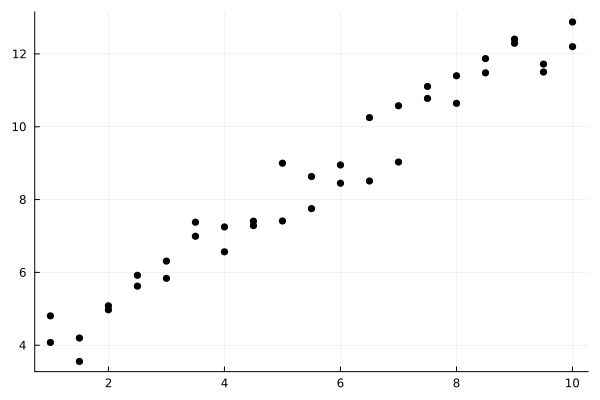

In [31]:
#Produce Synthetic Data
xvals = repeat(1:0.5:10, inner=2)
yvals = 3 .+ xvals .+ 2 .* rand(length(xvals)) .-1
scatter(xvals, yvals, color=:black, leg=false)

In [32]:
#Setup for Linear Regression
function find_best_fit(xvals,yvals)
    meanx = mean(xvals)
    meany = mean(yvals)
    stdx = std(xvals)
    stdy = std(yvals)
    r = cor(xvals,yvals)
    a = r*stdy/stdx
    b = meany - a*meanx
    return a,b
end

find_best_fit (generic function with 1 method)

In [33]:
a,b = find_best_fit(xvals,yvals)
ynew = a .* xvals .+ b

38-element Vector{Float64}:
  4.14223387643296
  4.14223387643296
  4.623753503327261
  4.623753503327261
  5.105273130221562
  5.105273130221562
  5.586792757115863
  5.586792757115863
  6.068312384010165
  6.068312384010165
  6.549832010904465
  6.549832010904465
  7.0313516377987675
  ⋮
 10.401989026058875
 10.401989026058875
 10.883508652953177
 10.883508652953177
 11.365028279847479
 11.365028279847479
 11.84654790674178
 11.84654790674178
 12.32806753363608
 12.32806753363608
 12.80958716053038
 12.80958716053038

In [34]:
np = pyimport("numpy"); #import numpy as np, essentially

  1.463274 seconds (1.81 M allocations: 96.372 MiB, 5.09% gc time, 70.30% compilation time)


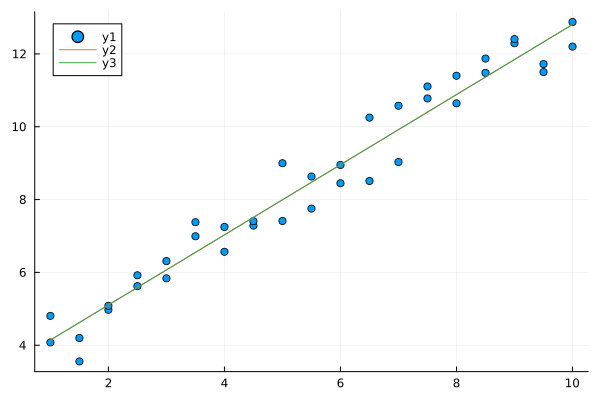

In [35]:
xdata = xvals
ydata = yvals
@time myfit = np.polyfit(xdata, ydata, 1);
ynew2 = collect(xdata) .* myfit[1] .+ myfit[2];
scatter(xvals,yvals)
plot!(xvals,ynew)
plot!(xvals,ynew2)

In [36]:
data = DataFrame(X=xdata, Y=ydata)
ols = lm(@formula(Y ~ X), data)
plot!(xdata,predict(ols))

LoadError: UndefVarError: predict not defined